# Fitting a TDS spectrum

In this task, we'll perform an automated identification of trapping site properties using a parametric optimisation algorithm.
See [R. Delaporte-Mathurin et al. NME (2021)](https://doi.org/10.1016/j.nme.2021.100984) for more details.

## TDS model

We have to define our FESTIM model, which we'll use in both task steps. The simulation will be performed for the case of H desorption from a W domain. Using the HTM library, we can get parameters of the H diffusivity in W that are required to set up the model.

In [1]:
import h_transport_materials as htm

D = (
    htm.diffusivities.filter(material="tungsten")
    .filter(isotope="h")
    .filter(author="fernandez")[0]
)
print(D)


        Author: Fernandez
        Material: tungsten
        Year: 2015
        Isotope: H
        Pre-exponential factor: 1.93×10⁻⁷ m²/s
        Activation energy: 2.00×10⁻¹ eV/particle
        


For this task, we'll consider a simplified simulation scenario. Firstly, we'll set only one sort of trapping site characterised by a detrapping barrier `E_p` [eV] and uniformly distributed in the W domain with concentration `n` [at. fr.]. Secondly, we'll assume that this W sample was kept in a H environment infinetly long, so all the trap sites were filled with H atoms. Thirdly, we'll suppose that all mobile H atoms leave the sample before the TDS. Finally, we'll simulate simulate the TDS phase assuming a uniform heating ramp of 5 K/s.

The initial conditions are:
$$ \left.c_{\mathrm{m}}\right\vert_{t=0}=0 $$
$$ \left.c_{\mathrm{t}}\right\vert_{t=0}=n $$
which we'll set using the `InitialCondition` class.

For the boundary conditions, we'll use the assumption of an instantaneous recombination (using `FixedConcentrationBC`):
$$ \left.c_{\mathrm{m}}\right\vert_{x=0}=\left.c_{\mathrm{m}}\right\vert_{x=L}=0 $$

For the fitting stage, we have to treat the detrapping energy and the trap concentration as variable parameters. Therefore, we'll define a function that encapsulates our `Simulation` object and accepts two input parameters: the trap density and detrapping energy.

In [2]:
import festim as F
import numpy as np


def temperature(t):
    ramp = 5  # K/s
    return 300 + ramp * t


def TDS(n, E_p):
    """Runs the simulation with parameters p that represent:

    Args:
        n (float): concentration of trap 1, at. fr.
        E_p (float): detrapping barrier from trap 1, eV

    Returns:
        F.DerivedQuantities: the derived quantities of the simulation
    """
    w_atom_density = 6.3e28  # atom/m3
    trap_conc = n * w_atom_density

    # Define Simulation object
    synthetic_TDS = F.HydrogenTransportProblem()

    H = F.Species("H")
    trapped_species = F.Species("H_trapped", mobile=False)
    synthetic_TDS.species = [H, trapped_species]

    # Define a simple mesh
    vertices = np.linspace(0, 20e-6, num=200)
    synthetic_TDS.mesh = F.Mesh1D(vertices)

    # Define material properties
    tungsten = F.Material(
        D_0=D.pre_exp.magnitude,
        E_D=D.act_energy.magnitude,
    )

    boundary_left = F.SurfaceSubdomain1D(id=1, x=0)
    boundary_right = F.SurfaceSubdomain1D(id=2, x=20e-6)
    volume_subdomain = F.VolumeSubdomain1D(id=3, borders=[0, 20e-6], material=tungsten)
    synthetic_TDS.subdomains = [boundary_left, boundary_right, volume_subdomain]

    # Define traps

    empty_trap = F.ImplicitSpecies(
        n=trap_conc,
        others=[trapped_species],
    )
    trap_1_reaction = F.Reaction(
        reactant=[H, empty_trap],
        product=[trapped_species],
        k_0=D.pre_exp.magnitude / (1.1e-10**2 * 6 * w_atom_density),
        E_k=D.act_energy.magnitude,
        p_0=1e13,
        E_p=E_p,
        volume=volume_subdomain,
    )

    synthetic_TDS.reactions = [trap_1_reaction]

    # Set initial conditions
    synthetic_TDS.initial_conditions = [
        F.InitialCondition(species=trapped_species, value=trap_conc),
    ]

    # Set boundary conditions
    synthetic_TDS.boundary_conditions = [
        F.FixedConcentrationBC(subdomain=surf, value=0, species=H)
        for surf in [boundary_left, boundary_right]
    ]

    # Define the material temperature evolution
    synthetic_TDS.temperature = temperature

    # Define the simulation settings
    synthetic_TDS.settings = F.Settings(
        atol=1e10,
        rtol=1e-10,
        final_time=140,
        max_iterations=50,
    )

    synthetic_TDS.settings.stepsize = F.Stepsize(
        initial_value=0.01,
        growth_factor=1.2,
        cutback_factor=0.9,
        target_nb_iterations=4,
        max_stepsize=lambda t: None if t < 1 else 1,
    )

    fluxes = [
        F.SurfaceFlux(field=H, surface=boundary_left),
        F.SurfaceFlux(field=H, surface=boundary_right),
    ]

    synthetic_TDS.exports = fluxes
    synthetic_TDS.initialise()
    synthetic_TDS.run()

    return fluxes

## Generate dummy data

Now we can generate a reference TDS spectrum. For the reference case, we'll consider the following parameters: $n=0.01~\text{at.fr}$ and $E_p=1~\text{eV}$.

In [3]:
reference_prms = [1e-2, 1.0]
data = TDS(*reference_prms)

Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Additionally, we can add some noise to the generated TDS spectra to mimic the experimental conditions. We'll also save the noisy flux dependence on temperature into a file to use it further as a reference data.

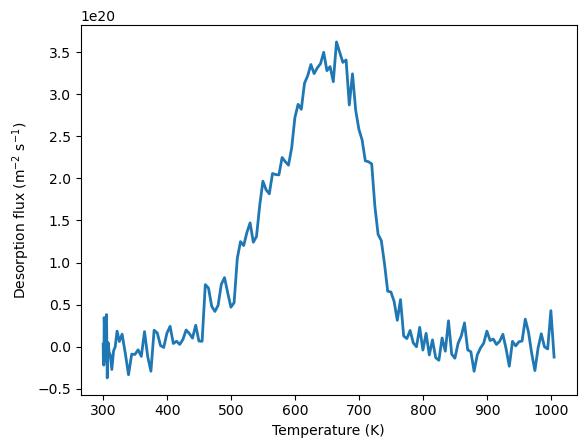

In [4]:
import matplotlib.pyplot as plt


# Calculate the total desorption flux
flux_left = data[0].data
flux_right = data[1].data
flux_total = np.array(flux_left) + np.array(flux_right)

# Get temperature
T = temperature(np.array(data[0].t))

# Add random noise
noise = np.random.normal(0, 0.05 * max(flux_total), len(flux_total))
noisy_flux = flux_total + noise

# Save to file
np.savetxt("Noisy_TDS.csv", np.column_stack([T, noisy_flux]), delimiter=";", fmt="%f")

# Visualise
plt.plot(T, noisy_flux, linewidth=2)

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Temperature (K)")
plt.show()

# Automated TDS fit

Here we'll define the algorithm to fit the generated TDS spectra using the [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) method from the `scipy.optimize` python library. The initial implementation of the algorithm can be found in [this repository](https://github.com/RemDelaporteMathurin/tds_optimisation/tree/main). We'll try to find the values of the detrapping barrier and the trap concetration so the average absolute error between the reference and the fitted spectras satisfies the required tolerance. To start with, we'll read our reference data and define an auxiliary method to display information on the status of fitting.

In [5]:
ref = np.genfromtxt("Noisy_TDS.csv", delimiter=";")


def info(xk):
    """
    Print information during the fitting procedure
    """
    print("-" * 40)
    print("New iteration.")
    print(f"Point is: {xk}")

Then, we define an error function `error_function` that:
- runs the TDS model with a given set of parameters
- calculates the mean absolute error between the reference and the simulated TDS
- collects intermediate values of parameters and the calculated errors for visualisation purposes

In [8]:
from scipy.interpolate import interp1d

prms = []
errors = []

all_ts = []
all_fluxes = []

i = 0  # initialise counter


def error_function(prm):
    """
    Compute average absolute error between simulation and reference
    """
    global i
    global prms
    global errors
    global all_ts
    global all_fluxes

    i += 1
    prms.append(prm)

    # Filter the results if a negative value is found
    if any([e < 0 for e in prm]):
        return 1e30

    # Get the simulation result
    n, Ep = prm
    res = TDS(n, Ep)

    flux = np.array(res[0].data) + np.array(res[1].data)
    all_fluxes.append(flux)
    all_ts.append(np.array(res[0].t))

    T = temperature(np.array(res[0].t))

    interp_tds = interp1d(T, flux, fill_value="extrapolate")

    # Compute the mean absolute error between sim and ref
    err = np.abs(interp_tds(ref[:, 0]) - ref[:, 1]).mean()

    print(f"Average absolute error is : {err:.2e}")
    errors.append(err)
    return err

Finally, we'll minimise `error_function` to find the set of trap properties reproducing the reference TDS (within some tolerance). 

We'll use the Nelder-Mead minimisation algorithm with the initial guess: $n=0.02~\text{at.fr.}$ and $E_p=1.1~\text{eV}$.

In [9]:
from scipy.optimize import minimize


# Set the tolerances
fatol = 1e18
xatol = 1e-3

initial_guess = [2e-2, 1.1]

# Minimise the error function
res = minimize(
    error_function,
    np.array(initial_guess),
    method="Nelder-Mead",
    options={"disp": True, "fatol": fatol, "xatol": xatol},
    callback=info,
)

Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.03e+20


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.09e+20


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.28e+20


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 9.51e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 9.68e+19
----------------------------------------
New iteration.
Point is: [0.021 1.045]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 8.78e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 8.19e+19
----------------------------------------
New iteration.
Point is: [0.0195 1.0175]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 8.90e+19
----------------------------------------
New iteration.
Point is: [0.0195 1.0175]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 7.86e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.00e+20
----------------------------------------
New iteration.
Point is: [0.019 0.935]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 7.00e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 6.06e+19
----------------------------------------
New iteration.
Point is: [0.01675 1.00375]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 6.84e+19
----------------------------------------
New iteration.
Point is: [0.01675 1.00375]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 3.96e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 2.42e+19
----------------------------------------
New iteration.
Point is: [0.0115 1.0175]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 6.24e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 4.59e+19
----------------------------------------
New iteration.
Point is: [0.0115 1.0175]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 3.95e+19
----------------------------------------
New iteration.
Point is: [0.0115 1.0175]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 3.50e+19
----------------------------------------
New iteration.
Point is: [0.0115 1.0175]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.80e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 4.22e+19
----------------------------------------
New iteration.
Point is: [0.0099375 0.9796875]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 4.87e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 2.00e+19
----------------------------------------
New iteration.
Point is: [0.0099375 0.9796875]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 3.18e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.58e+19
----------------------------------------
New iteration.
Point is: [0.01035547 1.00740234]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 2.52e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.46e+19
----------------------------------------
New iteration.
Point is: [0.00931543 1.0042334 ]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 2.48e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.34e+19
----------------------------------------
New iteration.
Point is: [0.00988647 0.99275269]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.82e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.41e+19
----------------------------------------
New iteration.
Point is: [0.00988647 0.99275269]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.50e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.35e+19
----------------------------------------
New iteration.
Point is: [0.00988647 0.99275269]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.46e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.34e+19
----------------------------------------
New iteration.
Point is: [0.00988647 0.99275269]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.36e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.32e+19
----------------------------------------
New iteration.
Point is: [0.00975024 0.99868968]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.38e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.31e+19
----------------------------------------
New iteration.
Point is: [0.00984253 0.99782183]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.40e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.31e+19
----------------------------------------
New iteration.
Point is: [0.00984143 0.99550422]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.31e+19
----------------------------------------
New iteration.
Point is: [0.00984143 0.99550422]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.34e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.30e+19
----------------------------------------
New iteration.
Point is: [0.00986505 0.99644606]


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.31e+19


Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

Average absolute error is : 1.30e+19
----------------------------------------
New iteration.
Point is: [0.00986505 0.99644606]
----------------------------------------
New iteration.
Point is: [0.00986505 0.99644606]
Optimization terminated successfully.
         Current function value: 13023264161240381440.000000
         Iterations: 25
         Function evaluations: 46


## Visualise results

Solving HydrogenTransportProblem:   0%|          | 0.00/140 [00:00<?, ?it/s]

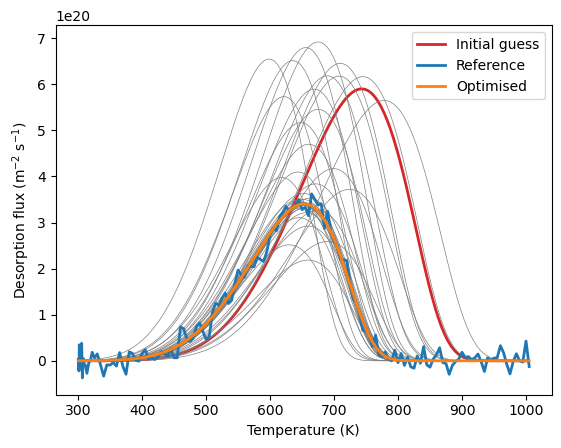

In [ ]:
# Process the obtained results
predicted_data = TDS(*res.x)

T = temperature(np.array(predicted_data[0].t))

flux_left = predicted_data[0].data
flux_right = predicted_data[1].data
flux_total = np.array(flux_left) + np.array(flux_right)

for i, (t, flux) in enumerate(zip(all_ts, all_fluxes)):
    T = temperature(t)
    if i == 0:
        plt.plot(T, flux, color="tab:red", lw=2, label="Initial guess")
    else:
        plt.plot(T, flux, color="tab:grey", lw=0.5)

plt.plot(ref[:, 0], ref[:, 1], linewidth=2, label="Reference")
plt.plot(T, flux_total, linewidth=2, label="Optimised")

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Temperature (K)")
plt.legend()
plt.show()

Additionally, we can visualise how the parameters and the computed error varied during the optimisation process.

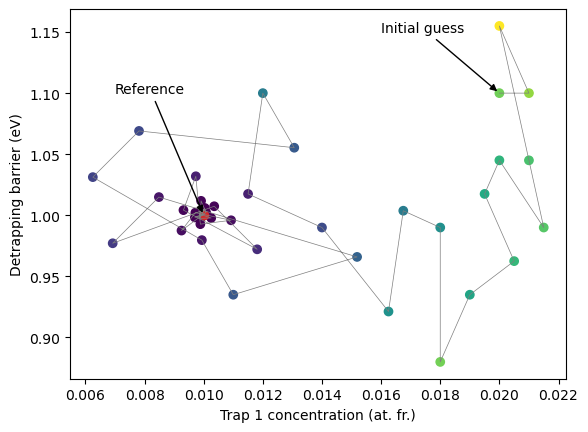

In [ ]:
plt.scatter(
    np.array(prms)[:, 0], np.array(prms)[:, 1], c=np.array(errors), cmap="viridis"
)
plt.plot(np.array(prms)[:, 0], np.array(prms)[:, 1], color="tab:grey", lw=0.5)

plt.scatter(*reference_prms, c="tab:red")
plt.annotate(
    "Reference",
    xy=reference_prms,
    xytext=(reference_prms[0] - 0.003, reference_prms[1] + 0.1),
    arrowprops=dict(facecolor="black", arrowstyle="-|>"),
)
plt.annotate(
    "Initial guess",
    xy=initial_guess,
    xytext=(initial_guess[0] - 0.004, initial_guess[1] + 0.05),
    arrowprops=dict(facecolor="black", arrowstyle="-|>"),
)

plt.xlabel(r"Trap 1 concentration (at. fr.)")
plt.ylabel(r"Detrapping barrier (eV)")
plt.show()